# Agregar variables al DF para ver si mejora el rendimiento
- voy a agregar head to head sin leakage (dos columnas nuevas)
    - hth_a_b = % de veces que a ha gando sobre b
    - hth_times = número de veces que se han enfrentado
    Lo hice así para no trabajr con datos que son vectores en una columna (ej. 2,3) 
- agregar todos los datos del partido anteriror (serve points, winner) de cada jugador
- agregar rest_a, rest_b (diferencia entre fecha actual y última vez que jugaron en ATP)

## Load data

In [287]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import random
import os

In [288]:

# ------- Config --------

FOLDER = "Datos"          # Carpeta con CSVs
REPORT = "profile.html"   # Salida del reporte
SAMPLE = None             # e.g., 20000 para muestrear filas si es muy grande

# 1) Cargar y unir CSVs
files = [f for f in os.listdir(FOLDER) if f.lower().endswith(".csv")]
if not files:
    raise FileNotFoundError(f"No hay CSVs en '{FOLDER}'")

dfs = []
for f in files:
    path = os.path.join(FOLDER, f)
    # dtype=object evita inferencias agresivas; luego convertimos
    df_part = pd.read_csv(path, dtype=object, low_memory=False)
    df_part["__archivo_origen"] = f
    dfs.append(df_part)

df = pd.concat(dfs, ignore_index=True)

In [289]:
df.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,__archivo_origen
0,2024-0339,Brisbane,Hard,32,A,20240101,300,105777,2,NaN,...,44,16,11,8,9,14,2570,8,3660,atp_matches_2024.csv
1,2024-0339,Brisbane,Hard,32,A,20240101,299,208029,1,NaN,...,31,10,11,5,7,8,3660,39,1122,atp_matches_2024.csv
2,2024-0339,Brisbane,Hard,32,A,20240101,298,105777,2,NaN,...,24,14,10,5,7,14,2570,55,902,atp_matches_2024.csv
3,2024-0339,Brisbane,Hard,32,A,20240101,297,208029,1,NaN,...,31,16,10,3,5,8,3660,116,573,atp_matches_2024.csv
4,2024-0339,Brisbane,Hard,32,A,20240101,296,126128,NaN,NaN,...,27,16,10,5,8,39,1122,44,1021,atp_matches_2024.csv


In [290]:
drop_cols = [
    '__archivo_origen'
]

df = df.drop(columns=drop_cols, errors='ignore')

# Convertir todo lo posible a numérico
df = df.apply(pd.to_numeric, errors='ignore')

# Eliminar filas con NaN en variables críticas
df = df.dropna(subset=['winner_rank', 'loser_rank'])

# Crear variable binaria objetivo (1 = ganó jugador 1)
df['target'] = 1  # En tu df el "winner" siempre está identificado, luego cambiaremos

/var/folders/5x/v_n3jdfd003f7mqj3m9j1k0h0000gn/T/ipykernel_66107/907754557.py:8: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


In [291]:
df

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,target
0,2024-0339,Brisbane,Hard,32,A,20240101,300,105777,2.0,NaN,...,44.0,16.0,11.0,8.0,9.0,14.0,2570.0,8.0,3660.0,1
1,2024-0339,Brisbane,Hard,32,A,20240101,299,208029,1.0,NaN,...,31.0,10.0,11.0,5.0,7.0,8.0,3660.0,39.0,1122.0,1
2,2024-0339,Brisbane,Hard,32,A,20240101,298,105777,2.0,NaN,...,24.0,14.0,10.0,5.0,7.0,14.0,2570.0,55.0,902.0,1
3,2024-0339,Brisbane,Hard,32,A,20240101,297,208029,1.0,NaN,...,31.0,16.0,10.0,3.0,5.0,8.0,3660.0,116.0,573.0,1
4,2024-0339,Brisbane,Hard,32,A,20240101,296,126128,NaN,NaN,...,27.0,16.0,10.0,5.0,8.0,39.0,1122.0,44.0,1021.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13169,2021-9210,Laver Cup,Hard,8,A,20210924,102,126610,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,7.0,5173.0,11.0,3368.0,1
13170,2021-9210,Laver Cup,Hard,8,A,20210924,103,106421,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.0,10575.0,12.0,3310.0,1
13171,2021-9210,Laver Cup,Hard,8,A,20210924,104,126094,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5.0,6130.0,15.0,2800.0,1
13172,2021-9210,Laver Cup,Hard,8,A,20210924,105,100644,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.0,7760.0,22.0,2171.0,1


Remplazamos lo del winner por a y lo de loser por b. 

In [292]:
import pandas as pd

def rename_players(df: pd.DataFrame, *, inplace: bool = False) -> pd.DataFrame:
    """
    Renombra prefijos de columnas de tenis a formato simétrico A/B:
      - 'winner_' -> 'a_'
      - 'loser_'  -> 'b_'
      - 'w_'      -> 'a_'
      - 'l_'      -> 'b_'

    No toca columnas sin esos prefijos.
    """
    # Orden importa: primero los prefijos largos para evitar conflictos
    rules = [
        ("winner_", "a_"),
        ("loser_",  "b_"),
        ("w_",      "a_"),
        ("l_",      "b_"),
    ]

    mapping = {}
    cols = list(df.columns)

    for c in cols:
        for old, new in rules:
            if c.startswith(old):
                mapping[c] = new + c[len(old):]
                break  # ya aplicamos una regla, pasamos a la siguiente columna

    if inplace:
        df.rename(columns=mapping, inplace=True)
        return df
    else:
        return df.rename(columns=mapping)

# Uso:
ab = rename_players(df)          # nuevo DataFrame
# o
rename_players(df, inplace=True) # renombra en el mismo df


,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,a_id,a_seed,a_entry,...,b_1stWon,b_2ndWon,b_SvGms,b_bpSaved,b_bpFaced,a_rank,a_rank_points,b_rank,b_rank_points,target
0,2024-0339,Brisbane,Hard,32,A,20240101,300,105777,2.0,NaN,...,44.0,16.0,11.0,8.0,9.0,14.0,2570.0,8.0,3660.0,1
1,2024-0339,Brisbane,Hard,32,A,20240101,299,208029,1.0,NaN,...,31.0,10.0,11.0,5.0,7.0,8.0,3660.0,39.0,1122.0,1
2,2024-0339,Brisbane,Hard,32,A,20240101,298,105777,2.0,NaN,...,24.0,14.0,10.0,5.0,7.0,14.0,2570.0,55.0,902.0,1
3,2024-0339,Brisbane,Hard,32,A,20240101,297,208029,1.0,NaN,...,31.0,16.0,10.0,3.0,5.0,8.0,3660.0,116.0,573.0,1
4,2024-0339,Brisbane,Hard,32,A,20240101,296,126128,NaN,NaN,...,27.0,16.0,10.0,5.0,8.0,39.0,1122.0,44.0,1021.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13169,2021-9210,Laver Cup,Hard,8,A,20210924,102,126610,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,7.0,5173.0,11.0,3368.0,1
13170,2021-9210,Laver Cup,Hard,8,A,20210924,103,106421,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.0,10575.0,12.0,3310.0,1
13171,2021-9210,Laver Cup,Hard,8,A,20210924,104,126094,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5.0,6130.0,15.0,2800.0,1
13172,2021-9210,Laver Cup,Hard,8,A,20210924,105,100644,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.0,7760.0,22.0,2171.0,1


In [293]:
df

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,a_id,a_seed,a_entry,...,b_1stWon,b_2ndWon,b_SvGms,b_bpSaved,b_bpFaced,a_rank,a_rank_points,b_rank,b_rank_points,target
0,2024-0339,Brisbane,Hard,32,A,20240101,300,105777,2.0,NaN,...,44.0,16.0,11.0,8.0,9.0,14.0,2570.0,8.0,3660.0,1
1,2024-0339,Brisbane,Hard,32,A,20240101,299,208029,1.0,NaN,...,31.0,10.0,11.0,5.0,7.0,8.0,3660.0,39.0,1122.0,1
2,2024-0339,Brisbane,Hard,32,A,20240101,298,105777,2.0,NaN,...,24.0,14.0,10.0,5.0,7.0,14.0,2570.0,55.0,902.0,1
3,2024-0339,Brisbane,Hard,32,A,20240101,297,208029,1.0,NaN,...,31.0,16.0,10.0,3.0,5.0,8.0,3660.0,116.0,573.0,1
4,2024-0339,Brisbane,Hard,32,A,20240101,296,126128,NaN,NaN,...,27.0,16.0,10.0,5.0,8.0,39.0,1122.0,44.0,1021.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13169,2021-9210,Laver Cup,Hard,8,A,20210924,102,126610,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,7.0,5173.0,11.0,3368.0,1
13170,2021-9210,Laver Cup,Hard,8,A,20210924,103,106421,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.0,10575.0,12.0,3310.0,1
13171,2021-9210,Laver Cup,Hard,8,A,20210924,104,126094,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5.0,6130.0,15.0,2800.0,1
13172,2021-9210,Laver Cup,Hard,8,A,20210924,105,100644,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.0,7760.0,22.0,2171.0,1


In [294]:
[c for c in df.columns if c.endswith('_seed') or c.endswith('_entry')]


['a_seed', 'a_entry', 'b_seed', 'b_entry']

In [295]:
df.isna().sum().sort_values(ascending=False)


a_entry          10967
b_entry           9980
b_seed            9739
a_seed            7490
minutes            792
b_1stIn            468
a_svpt             468
a_df               468
a_ace              468
a_2ndWon           468
a_SvGms            468
a_bpSaved          468
a_bpFaced          468
b_ace              468
b_df               468
b_svpt             468
a_1stIn            468
a_1stWon           468
b_1stWon           468
b_2ndWon           468
b_SvGms            468
b_bpSaved          468
b_bpFaced          468
b_ht                48
surface             36
a_ht                22
a_rank               0
a_rank_points        0
b_rank               0
b_rank_points        0
tourney_id           0
round                0
tourney_name         0
best_of              0
draw_size            0
tourney_level        0
tourney_date         0
match_num            0
a_id                 0
a_name               0
a_hand               0
a_ioc                0
a_age                0
b_id       

Quitamos el entry, no creo que importe tanto

In [296]:
# Safe drop (won't error if a_seed/b_seed are missing)
df = df.drop(columns=['a_entry', 'b_entry'], errors='ignore')


In [297]:
import numpy as np
import pandas as pd

def impute_seeds(df,
                 a_seed='a_seed', b_seed='b_seed',
                 a_rank='a_rank', b_rank='b_rank'):
    def _impute(col_seed, col_rank):
        if col_seed in df.columns:
            r = df[col_rank] if col_rank in df.columns else np.nan
            df[col_seed] = np.where(
                df[col_seed].isna(),
                np.where(pd.isna(r), 2000, 1000 + pd.to_numeric(r, errors='coerce')),
                df[col_seed]
            )
    _impute(a_seed, a_rank)
    _impute(b_seed, b_rank)
    return df

df = impute_seeds(df)  # will silently skip if a_seed/b_seed don’t exist


In [298]:
df

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,a_id,a_seed,a_name,...,b_1stWon,b_2ndWon,b_SvGms,b_bpSaved,b_bpFaced,a_rank,a_rank_points,b_rank,b_rank_points,target
0,2024-0339,Brisbane,Hard,32,A,20240101,300,105777,2.0,Grigor Dimitrov,...,44.0,16.0,11.0,8.0,9.0,14.0,2570.0,8.0,3660.0,1
1,2024-0339,Brisbane,Hard,32,A,20240101,299,208029,1.0,Holger Rune,...,31.0,10.0,11.0,5.0,7.0,8.0,3660.0,39.0,1122.0,1
2,2024-0339,Brisbane,Hard,32,A,20240101,298,105777,2.0,Grigor Dimitrov,...,24.0,14.0,10.0,5.0,7.0,14.0,2570.0,55.0,902.0,1
3,2024-0339,Brisbane,Hard,32,A,20240101,297,208029,1.0,Holger Rune,...,31.0,16.0,10.0,3.0,5.0,8.0,3660.0,116.0,573.0,1
4,2024-0339,Brisbane,Hard,32,A,20240101,296,126128,1039.0,Roman Safiullin,...,27.0,16.0,10.0,5.0,8.0,39.0,1122.0,44.0,1021.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13169,2021-9210,Laver Cup,Hard,8,A,20210924,102,126610,1007.0,Matteo Berrettini,...,NaN,NaN,NaN,NaN,NaN,7.0,5173.0,11.0,3368.0,1
13170,2021-9210,Laver Cup,Hard,8,A,20210924,103,106421,1002.0,Daniil Medvedev,...,NaN,NaN,NaN,NaN,NaN,2.0,10575.0,12.0,3310.0,1
13171,2021-9210,Laver Cup,Hard,8,A,20210924,104,126094,1005.0,Andrey Rublev,...,NaN,NaN,NaN,NaN,NaN,5.0,6130.0,15.0,2800.0,1
13172,2021-9210,Laver Cup,Hard,8,A,20210924,105,100644,1004.0,Alexander Zverev,...,NaN,NaN,NaN,NaN,NaN,4.0,7760.0,22.0,2171.0,1


In [299]:
import pandas as pd
import numpy as np

# df is assumed loaded already, e.g.:
# df = pd.read_csv("your_ab_dataset.csv")

# ---- Small utility to backfill A/B columns if your df still has winner/loser or w_/l_ ----
def _copy_if_missing(df, dst, src_options):
    """Create df[dst] from the first existing column in src_options, if dst is missing."""
    if dst in df.columns:
        return df
    for src in src_options:
        if src in df.columns:
            df[dst] = df[src]
            return df
    return df  # no-op if not found

# Ensure minimal A/B schema exists, copying from winner/loser or w_/l_ if necessary
for dst, srcs in [
    ('a_id',   ['winner_id', 'w_id']),
    ('b_id',   ['loser_id',  'l_id']),
    ('a_rank', ['winner_rank', 'w_rank']),
    ('b_rank', ['loser_rank',  'l_rank']),
    ('a_seed', ['winner_seed', 'w_seed']),
    ('b_seed', ['loser_seed',  'l_seed']),
]:
    df = _copy_if_missing(df, dst, srcs)

# ---- Required columns check ----
required = ['tourney_date','a_id','b_id']
missing_req = [c for c in required if c not in df.columns]
if missing_req:
    raise KeyError(f"Missing required columns: {missing_req}")

# ---- Parse/normalize date & ordering (avoid leakage) ----
if df['tourney_date'].dtype != 'datetime64[ns]':
    df['tourney_date'] = pd.to_datetime(df['tourney_date'].astype(str), format='%Y%m%d', errors='coerce')

if 'match_num' not in df.columns:
    df['match_num'] = np.arange(len(df), dtype=int)

df = df.sort_values(['tourney_date', 'match_num']).reset_index(drop=True)


Head to head sin leakage

In [ ]:
# Choose which numeric stats to carry from *previous* match
PREV_NUM_STATS = [
    'svpt','1stIn','1stWon','2ndWon','SvGms','bpSaved','bpFaced',
    'rank','rank_points'
]

def stack_players(df):
    keep_cols = ['tourney_date','match_num','target','a_id','b_id']
    a_cols = [f'a_{c}' for c in PREV_NUM_STATS if f'a_{c}' in df.columns]
    b_cols = [f'b_{c}' for c in PREV_NUM_STATS if f'b_{c}' in df.columns]
    base = df[sorted(set(keep_cols + a_cols + b_cols))].copy()

    def to_side(side):
        opp = 'b' if side == 'a' else 'a'
        out = base[['tourney_date','match_num','target','a_id','b_id']].copy()
        out['player_id'] = base[f'{side}_id'].astype(int)
        out['opp_id']    = base[f'{opp}_id'].astype(int)
        if 'target' in out.columns:
            out['player_won'] = (base['target'] == (1 if side=='a' else 0)).astype(int)
        for c in PREV_NUM_STATS:
            col = f'{side}_{c}'
            if col in base.columns:
                out[f'p_{c}'] = base[col]
        return out

    long_df = pd.concat([to_side('a'), to_side('b')], ignore_index=True)
    return long_df.sort_values(['player_id','tourney_date','match_num']).reset_index(drop=True)

long_df = stack_players(df)

# lag (previous match) within each player
long_df[['prev_date','prev_won']] = long_df.groupby('player_id')[['tourney_date','player_won']].shift(1)
for c in [f'p_{x}' for x in PREV_NUM_STATS if f'p_{x}' in long_df.columns]:
    long_df[f'prev_{c[2:]}'] = long_df.groupby('player_id')[c].shift(1)

# rest in days since last match
long_df['rest_days'] = (long_df['tourney_date'] - long_df['prev_date']).dt.days

# Build side tables and rename properly
prev_cols = ['player_id','tourney_date','match_num','prev_won','rest_days'] + \
            [c for c in long_df.columns if c.startswith('prev_')]

prevA = long_df[prev_cols].copy()
renameA = {'player_id':'a_id', 'prev_won':'a_prev_won', 'rest_days':'rest_a'}
for c in prevA.columns:
    if c.startswith('prev_'):
        renameA[c] = f"a_prev_{c.replace('prev_','')}"
prevA = prevA.rename(columns=renameA)

prevB = long_df[prev_cols].copy()
renameB = {'player_id':'b_id', 'prev_won':'b_prev_won', 'rest_days':'rest_b'}
for c in prevB.columns:
    if c.startswith('prev_'):
        renameB[c] = f"b_prev_{c.replace('prev_','')}"
prevB = prevB.rename(columns=renameB)

# Merge back to the match-level df
df = df.merge(prevA, on=['a_id','tourney_date','match_num'], how='left')
df = df.merge(prevB, on=['b_id','tourney_date','match_num'], how='left')

# Ensure columns exist even if a player has no prior match
for col in ['rest_a','rest_b','a_prev_won','b_prev_won']:
    if col not in df.columns:
        df[col] = np.nan


Seed imputation (NaN → 1000 + rank; if rank NaN → 2000)

In [301]:
def impute_seeds(df, a_seed='a_seed', b_seed='b_seed', a_rank='a_rank', b_rank='b_rank'):
    def _impute(col_seed, col_rank):
        if col_seed in df.columns:
            r = pd.to_numeric(df[col_rank], errors='coerce') if col_rank in df.columns else np.nan
            s = pd.to_numeric(df[col_seed], errors='coerce')
            df[col_seed] = np.where(
                s.isna(),
                np.where(pd.isna(r), 2000, 1000 + r.astype('Int64')),
                s
            )
    _impute(a_seed, a_rank)
    _impute(b_seed, b_rank)
    return df

df = impute_seeds(df)


In [302]:
def safe_cols(frame, cols):
    ok = [c for c in cols if c in frame.columns]
    return frame[ok].head()

def safe_nulls(frame, col):
    return int(frame[col].isna().sum()) if col in frame.columns else "N/A"

print("H2H sample:\n",  safe_cols(df, ['a_id','b_id','hth_a_b','hth_times']))
print("Rest sample:\n",  safe_cols(df, ['a_id','rest_a','b_id','rest_b']))
print("Seed nulls → a_seed:", safe_nulls(df,'a_seed'), " b_seed:", safe_nulls(df,'b_seed'))


H2H sample:
      a_id    b_id
0  105357  200000
1  200282  133430
2  105357  133018
3  106401  126774
4  200000  133018
Rest sample:
      a_id  rest_a    b_id  rest_b
0  105357     NaN  200000     NaN
1  200282     NaN  133430     NaN
2  105357     0.0  133018     NaN
3  106401     NaN  126774     NaN
4  200000     0.0  133018     0.0
Seed nulls → a_seed: 0  b_seed: 0


In [303]:
import numpy as np
import pandas as pd

# =========================
# Leakage-safe H2H features
# =========================
# Output:
#   - df['hth_a_b']   : share of prior wins for player 'a' vs 'b'
#   - df['hth_times'] : number of prior meetings between a and b
#
# Requirements:
#   Columns: a_id, b_id
#   One of:  target (1 if 'a' won, 0 if 'a' lost)  OR  winner_id / w_id
#   Recommended for ordering: tourney_date (YYYYMMDD or ISO), round, match_num
#
# Notes:
#   - No leakage if your frame is truly chronological and each match’s rows are grouped (pair_id).
#   - If you lack pair_id (i.e., A/B mirrored rows), fallback processes 1-row groups and is safe
#     across time but can’t stop leakage *within* the same match if both rows are present together.
#     You should provide a reliable 'pair_id' to avoid that.

# -----------------------
# Config
# -----------------------
H2H_NEUTRAL_FOR_FIRST = 0.0  # set to 0.5 if you prefer neutral for first meeting

df = df.copy()

# -----------------------
# 1) Chronological order
# -----------------------
# Round order heuristic (customize to your data)
ROUND_ORDER = {'R128':1,'R64':2,'R32':3,'R16':4,'QF':5,'SF':6,'F':7}
# Date
if 'tourney_date' in df.columns:
    # Works for both "YYYYMMDD" ints/strings and ISO date strings
    df['__tdate'] = pd.to_datetime(df['tourney_date'], errors='coerce')
else:
    df['__tdate'] = pd.NaT

# Round
if 'round' in df.columns:
    df['__rorder'] = df['round'].map(ROUND_ORDER).fillna(0).astype(int)
else:
    df['__rorder'] = 0

# Match number
if 'match_num' in df.columns:
    df['__mnum'] = pd.to_numeric(df['match_num'], errors='coerce').fillna(0).astype(int)
else:
    df['__mnum'] = 0

# Sort stably to preserve relative order within ties
df.sort_values(['__tdate','__rorder','__mnum'], kind='mergesort', inplace=True)

# Critical for avoiding iloc/label mismatches later
df.reset_index(drop=True, inplace=True)

# -----------------------
# 2) Prepare containers
# -----------------------
hth_prior_wins  = {}   # key: (lo,hi) -> wins by 'lo'
hth_prior_times = {}   # key: (lo,hi) -> total meetings

n = len(df)
hth_share = np.zeros(n, dtype=float)
hth_times = np.zeros(n, dtype=int)

has_target   = 'target' in df.columns
has_winnerid = ('winner_id' in df.columns) or ('w_id' in df.columns)
wcol = 'winner_id' if 'winner_id' in df.columns else ('w_id' if 'w_id' in df.columns else None)

# -----------------------
# 3) Group per match
# -----------------------
if 'pair_id' in df.columns:
    gobj = df.groupby('pair_id', sort=False)
    iterator = gobj
    is_groupby = True
else:
    # Fallback: each row is its own "match"
    iterator = ((i, df.iloc[[i]]) for i in range(n))
    is_groupby = False

# -----------------------
# 4) Iterate groups
# -----------------------
for gid, g in (iterator if is_groupby else iterator):
    # Identify players from the first row in the group
    r0 = g.iloc[0]
    a0 = int(r0['a_id'])
    b0 = int(r0['b_id'])
    lo, hi = (a0, b0) if a0 < b0 else (b0, a0)
    key = (lo, hi)

    prior_w = hth_prior_wins.get(key, 0)
    prior_t = hth_prior_times.get(key, 0)

    # Compute features for all rows in the group from PRIOR snapshot
    for idx in g.index:
        a_i = int(df.at[idx, 'a_id'])
        b_i = int(df.at[idx, 'b_id'])

        if prior_t == 0:
            hth_share[idx] = H2H_NEUTRAL_FOR_FIRST
            hth_times[idx] = 0
        else:
            # If 'a' is the 'lo' player, share = wins_by_lo / prior_t; else complement
            if a_i < b_i:
                share_a = prior_w / prior_t
            else:
                share_a = (prior_t - prior_w) / prior_t
            hth_share[idx] = share_a
            hth_times[idx] = prior_t

    # AFTER computing features for the whole match, update the H2H tallies ONCE
    # Determine the winner_id for this match
    win_id = None
    if has_winnerid:
        # Assume consistency within the group; take the first non-null
        wi = pd.to_numeric(g[wcol], errors='coerce').dropna()
        if len(wi):
            win_id = int(wi.iloc[0])
    elif has_target:
        # Row with target==1 means 'a' won in that row -> winner is that row's a_id
        mask = (g['target'] == 1)
        if mask.any():
            win_id = int(g.loc[mask].iloc[0]['a_id'])

    # Apply update
    hth_prior_times[key] = prior_t + 1
    if win_id is None:
        # meeting with unknown winner: only time increments
        hth_prior_wins[key] = prior_w
    else:
        lo_won = (win_id == lo)
        hth_prior_wins[key] = prior_w + (1 if lo_won else 0)

# -----------------------
# 5) Assign + cleanup
# -----------------------
df['hth_a_b']   = hth_share
df['hth_times'] = hth_times
df.drop(columns=['__tdate','__rorder','__mnum'], inplace=True)

# df now contains leakage-safe H2H features


In [304]:
df

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,a_id,a_seed,a_name,...,b_prev_SvGms,b_prev_bpSaved,b_prev_bpFaced,b_prev_rank,b_prev_rank_points,b_prev_seed,b_prev_ht,b_prev_age,hth_a_b,hth_times
0,2020-8888,Atp Cup,Hard,24,A,2020-01-06,215,105357,1048.0,John Millman,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
1,2020-8888,Atp Cup,Hard,24,A,2020-01-06,216,200282,1018.0,Alex De Minaur,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
2,2020-8888,Atp Cup,Hard,24,A,2020-01-06,217,105357,1048.0,John Millman,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
3,2020-8888,Atp Cup,Hard,24,A,2020-01-06,218,106401,1029.0,Nick Kyrgios,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
4,2020-8888,Atp Cup,Hard,24,A,2020-01-06,219,200000,1021.0,Felix Auger Aliassime,...,14.0,2.0,4.0,486.0,62.0,1486.0,193.0,23.5,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12981,2024-7696,Next Gen Finals,Hard,8,F,2024-12-18,396,210530,5.0,Learner Tien,...,13.0,7.0,11.0,20.0,2355.0,1.0,185.0,20.5,0.0,1
12982,2024-7696,Next Gen Finals,Hard,8,F,2024-12-18,397,209950,1.0,Arthur Fils,...,15.0,0.0,1.0,48.0,1136.0,3.0,193.0,19.2,0.0,0
12983,2024-7696,Next Gen Finals,Hard,8,F,2024-12-18,398,210530,5.0,Learner Tien,...,4.0,0.0,0.0,41.0,1245.0,2.0,193.0,20.3,0.0,0
12984,2024-7696,Next Gen Finals,Hard,8,F,2024-12-18,399,211663,8.0,Joao Fonseca,...,11.0,1.0,3.0,128.0,471.0,6.0,178.0,20.5,0.0,0


In [305]:
import pandas as pd
import numpy as np

def resolve_duplicate_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    For each duplicated column name, keep exactly one column with the first non-null
    value across its duplicates (row-wise). No other columns are removed.
    """
    df = df.copy()
    dup_names = df.columns[df.columns.duplicated()].unique().tolist()
    if dup_names:
        print(f"[info] Resolving duplicates for: {dup_names[:10]}{' ...' if len(dup_names)>10 else ''}")
    for name in dup_names:
        same = [i for i, c in enumerate(df.columns) if c == name]
        cols = [df.columns[i] for i in same]
        # combine by first non-null along duplicates
        combined = df[cols].bfill(axis=1).iloc[:, 0]
        # assign back to the *first* occurrence
        first_col = cols[0]
        df[first_col] = combined
        # drop the extra copies
        to_drop = cols[1:]
        if to_drop:
            df.drop(columns=to_drop, inplace=True)
    return df

def clean_impute_zero(
    df: pd.DataFrame,
    *,
    drop_cat_nan: bool = True,
    rank_cols=None,
    seed_cols=None,
    inplace: bool = False
) -> pd.DataFrame:
    """
    1) Collapse duplicate-named columns by first non-null.
    2) Optionally drop rows with NaN in categorical columns.
    3) Convert dtypes; 0-impute numeric-like columns, EXCEPT rank/seed.
    4) Force prev_* and rest_* to numeric then fill 0.
    """
    if not inplace:
        df = df.copy()

    # 1) Remove/merge duplicates
    dup_cols = df.columns[df.columns.duplicated()].tolist()
    if dup_cols:
        print(f"[warn] collapsing duplicate columns (first 10): {dup_cols[:10]}")
        df = resolve_duplicate_columns(df)

    # 2) Drop NaN in categorical columns (surface, tourney_level, etc.)
    if drop_cat_nan:
        cat_cols = df.select_dtypes(include=["object","category","string","bool","boolean"]).columns.tolist()
        if cat_cols:
            df = df.dropna(subset=cat_cols)

    # 3) Convert dtypes; 0-impute numerics except rank/seed
    df = df.convert_dtypes()

    if rank_cols is None:
        rank_cols = [c for c in df.columns if c.lower().endswith("rank")]
    if seed_cols is None:
        seed_cols = [c for c in df.columns if c.lower().endswith("seed")]
    exclude = set(rank_cols + seed_cols)

    # Coerce each column to numeric where possible, then fillna(0) unless excluded
    for c in df.columns:
        if c in exclude:
            # still coerce to numeric if possible, but don't fill
            ser = pd.to_numeric(df[c], errors='coerce')
            df[c] = ser  # leave NaN as-is
            continue

        # Try numeric coercion; if any numeric info or any NaN present, adopt it
        ser = pd.to_numeric(df[c], errors='coerce')
        if ser.notna().any() or df[c].isna().any():
            df[c] = ser.fillna(0)

    # 4) Force prev_* and rest_* (sometimes come as object) → numeric then 0
    force_cols = [c for c in df.columns if c.startswith(('a_prev_','b_prev_'))]
    force_cols += [c for c in ['rest_a','rest_b'] if c in df.columns]
    for c in force_cols:
        df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0)

    return df


In [306]:
df = clean_impute_zero(
    df,
    drop_cat_nan=True,                 # drop rows with NaN in categoricals (e.g., 'surface')
    rank_cols=['a_rank','b_rank'],     # exclude from zero-imputation
    seed_cols=['a_seed','b_seed']      # exclude (or omit if you already dropped seeds)
)

# quick check
nan_cols = df.columns[df.isna().any()].tolist()
print("Still-NaN columns:", nan_cols[:30], "… total:", len(nan_cols))



[warn] collapsing duplicate columns (first 10): ['a_prev_won', 'b_prev_won']
[info] Resolving duplicates for: ['a_prev_won', 'b_prev_won']
Still-NaN columns: [] … total: 0


In [307]:
df

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,a_id,a_seed,a_name,...,b_prev_SvGms,b_prev_bpSaved,b_prev_bpFaced,b_prev_rank,b_prev_rank_points,b_prev_seed,b_prev_ht,b_prev_age,hth_a_b,hth_times
0,2020-8888,Atp Cup,Hard,24,A,1578268800000000000,215,105357,1048,John Millman,...,0,0,0,0,0,0,0,0.0,0.0,0
1,2020-8888,Atp Cup,Hard,24,A,1578268800000000000,216,200282,1018,Alex De Minaur,...,0,0,0,0,0,0,0,0.0,0.0,0
2,2020-8888,Atp Cup,Hard,24,A,1578268800000000000,217,105357,1048,John Millman,...,0,0,0,0,0,0,0,0.0,0.0,0
3,2020-8888,Atp Cup,Hard,24,A,1578268800000000000,218,106401,1029,Nick Kyrgios,...,0,0,0,0,0,0,0,0.0,0.0,0
4,2020-8888,Atp Cup,Hard,24,A,1578268800000000000,219,200000,1021,Felix Auger Aliassime,...,14,2,4,486,62,1486,193,23.5,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12981,2024-7696,Next Gen Finals,Hard,8,F,1734480000000000000,396,210530,5,Learner Tien,...,13,7,11,20,2355,1,185,20.5,0.0,1
12982,2024-7696,Next Gen Finals,Hard,8,F,1734480000000000000,397,209950,1,Arthur Fils,...,15,0,1,48,1136,3,193,19.2,0.0,0
12983,2024-7696,Next Gen Finals,Hard,8,F,1734480000000000000,398,210530,5,Learner Tien,...,4,0,0,41,1245,2,193,20.3,0.0,0
12984,2024-7696,Next Gen Finals,Hard,8,F,1734480000000000000,399,211663,8,Joao Fonseca,...,11,1,3,128,471,6,178,20.5,0.0,0


In [308]:

print("Shape after clean:", df.shape)

Shape after clean: (12950, 78)


In [309]:
import pandas as pd
import numpy as np

def fix_datetime_column(s: pd.Series) -> pd.Series:
    # si ya es datetime, no tocar
    if pd.api.types.is_datetime64_any_dtype(s):
        return s

    # si es numérica muy grande (ns desde época)
    if pd.api.types.is_integer_dtype(s) or pd.api.types.is_float_dtype(s):
        s2 = s.replace({0: np.nan})
        # Heurística: valores grandes -> probablemente ns
        if s2.dropna().astype(float).gt(1e12).mean() > 0.9:
            return pd.to_datetime(s2, unit='ns', errors='coerce')
        # si fueran segundos
        if s2.dropna().astype(float).between(1e9, 2e10).mean() > 0.9:
            return pd.to_datetime(s2, unit='s', errors='coerce')

    # si es string tipo YYYYMMDD
    return pd.to_datetime(s.astype(str), format='%Y%m%d', errors='coerce')

# aplicar
if 'tourney_date' in df.columns:
    df['tourney_date'] = fix_datetime_column(df['tourney_date'])


In [310]:
import pandas as pd
import numpy as np

def clean_keep_columns(
    df: pd.DataFrame,
    *,
    cat_subset=None,            # e.g. ['surface','tourney_level']
    rank_cols=None,             # e.g. ['a_rank','b_rank']
    seed_cols=None,             # e.g. ['a_seed','b_seed']
    protect_date_like=True,     # no tocar *_date, date, *_dt
) -> pd.DataFrame:
    df = df.copy()

    # 1) Resolver duplicados sin perder columnas
    def resolve_duplicate_columns(df_):
        dup_names = df_.columns[df_.columns.duplicated()].unique().tolist()
        for name in dup_names:
            cols = [c for c in df_.columns if c == name]
            combined = df_[cols].bfill(axis=1).iloc[:, 0]
            df_[cols[0]] = combined
            if len(cols) > 1:
                df_.drop(columns=cols[1:], inplace=True)
        return df_

    df = resolve_duplicate_columns(df)

    # 2) Drop NaN sólo en un subconjunto pequeño de categóricas (opcional)
    if cat_subset:
        present = [c for c in cat_subset if c in df.columns]
        if present:
            df = df.dropna(subset=present)

    # 3) Preparar listas de exclusión
    if rank_cols is None:
        rank_cols = [c for c in df.columns if c.lower().endswith('rank')]
    if seed_cols is None:
        seed_cols = [c for c in df.columns if c.lower().endswith('seed')]
    exclude = set(rank_cols + seed_cols)

    # Columnas de tiempo (no tocar)
    is_dt = df.columns[df.columns.map(lambda c: pd.api.types.is_datetime64_any_dtype(df[c]))]
    is_td = df.columns[df.columns.map(lambda c: pd.api.types.is_timedelta64_dtype(df[c]))]
    time_cols = set(is_dt).union(set(is_td))

    # Proteger por nombre (si parece fecha)
    if protect_date_like:
        name_protect = {c for c in df.columns
                        if c.lower().endswith(('date','_date','_dt','datetime')) or c.lower()=='date'}
        time_cols |= name_protect

    # 4) Convertir e imputar por columna: 0 para numéricas, salvo excluidas/tiempo
    for c in df.columns:
        if c in time_cols:
            # intentar arreglar si quedó mal tipada
            if not pd.api.types.is_datetime64_any_dtype(df[c]):
                df[c] = fix_datetime_column(df[c])
            continue

        if c in exclude:
            # convertir a numérico si se puede, pero NO rellenar
            df[c] = pd.to_numeric(df[c], errors='coerce')
            continue

        # para el resto: si puede ser numérico, convertir y rellenar con 0
        ser_num = pd.to_numeric(df[c], errors='coerce')
        if ser_num.notna().any() or df[c].isna().any():
            df[c] = ser_num.fillna(0)

    # 5) Forzar prev_* y rest_* a numérico + 0
    force_cols = [c for c in df.columns if c.startswith(('a_prev_','b_prev_'))]
    force_cols += [c for c in ['rest_a','rest_b'] if c in df.columns]
    for c in force_cols:
        if c not in time_cols and c not in exclude:
            df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0)

    return df


In [311]:
# (opcional) si no quieres semillas:
df = df.drop(columns=['a_seed','b_seed'], errors='ignore')

df = clean_keep_columns(
    df,
    cat_subset=['surface','tourney_level'],   # o déjalo vacío si no quieres dropear por categóricas
    rank_cols=['a_rank','b_rank'],
    seed_cols=['a_seed','b_seed'],
    protect_date_like=True
)

# Verifica que tourney_date está bien
print(df['tourney_date'].head(), df['tourney_date'].dtype)


0   2020-01-06
1   2020-01-06
2   2020-01-06
3   2020-01-06
4   2020-01-06
Name: tourney_date, dtype: datetime64[ns] datetime64[ns]


In [312]:
df.columns

Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'a_id', 'a_name', 'a_hand', 'a_ht',
       'a_ioc', 'a_age', 'b_id', 'b_name', 'b_hand', 'b_ht', 'b_ioc', 'b_age',
       'score', 'best_of', 'round', 'minutes', 'a_ace', 'a_df', 'a_svpt',
       'a_1stIn', 'a_1stWon', 'a_2ndWon', 'a_SvGms', 'a_bpSaved', 'a_bpFaced',
       'b_ace', 'b_df', 'b_svpt', 'b_1stIn', 'b_1stWon', 'b_2ndWon', 'b_SvGms',
       'b_bpSaved', 'b_bpFaced', 'a_rank', 'a_rank_points', 'b_rank',
       'b_rank_points', 'target', 'rest_a', 'a_prev_date', 'a_prev_svpt',
       'a_prev_1stIn', 'a_prev_1stWon', 'a_prev_2ndWon', 'a_prev_SvGms',
       'a_prev_bpSaved', 'a_prev_bpFaced', 'a_prev_rank', 'a_prev_rank_points',
       'a_prev_seed', 'a_prev_ht', 'a_prev_age', 'rest_b', 'b_prev_date',
       'b_prev_svpt', 'b_prev_1stIn', 'b_prev_1stWon', 'b_prev_2ndWon',
       'b_prev_SvGms', 'b_prev_bpSaved', 'b_prev_bpFaced', 'b_prev_rank',
       'b_prev_rank_p

Leakage

In [313]:
cols_to_drop = ['a_svpt', 'a_1stIn', 'a_1stWon', 'a_SvGms', 'a_bpFaced', 'b_svpt', 'b_1stIn', 'b_1stWon', 'b_SvGms', 'b_bpFaced',
                'minutes', 'a_2ndWon', 'a_bpSaved', 'a_ace', 'b_ace',
                'a_ace', 'a_df', 'b_ace', 'b_df', 'b_2ndWon', 'b_bpSaved']

In [314]:
# Dropea solo las que existan (por seguridad)
cols_present = [c for c in cols_to_drop if c in df.columns]
df = df.drop(columns=cols_present)

print(f"Se dropearon {len(cols_present)} columnas.")

Se dropearon 21 columnas.


In [315]:
df.columns

Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'a_id', 'a_name', 'a_hand', 'a_ht',
       'a_ioc', 'a_age', 'b_id', 'b_name', 'b_hand', 'b_ht', 'b_ioc', 'b_age',
       'score', 'best_of', 'round', 'a_rank', 'a_rank_points', 'b_rank',
       'b_rank_points', 'target', 'rest_a', 'a_prev_date', 'a_prev_svpt',
       'a_prev_1stIn', 'a_prev_1stWon', 'a_prev_2ndWon', 'a_prev_SvGms',
       'a_prev_bpSaved', 'a_prev_bpFaced', 'a_prev_rank', 'a_prev_rank_points',
       'a_prev_seed', 'a_prev_ht', 'a_prev_age', 'rest_b', 'b_prev_date',
       'b_prev_svpt', 'b_prev_1stIn', 'b_prev_1stWon', 'b_prev_2ndWon',
       'b_prev_SvGms', 'b_prev_bpSaved', 'b_prev_bpFaced', 'b_prev_rank',
       'b_prev_rank_points', 'b_prev_seed', 'b_prev_ht', 'b_prev_age',
       'hth_a_b', 'hth_times'],
      dtype='object')

Hacer el df balanceado en taregt

In [316]:
import pandas as pd
from sklearn.utils import shuffle

COLS_EXPECTED = [
 'tourney_id','tourney_name','surface','draw_size','tourney_level',
 'tourney_date','match_num','a_id','a_name','a_hand','a_ht',
 'a_ioc','a_age','b_id','b_name','b_hand','b_ht','b_ioc','b_age',
 'score','best_of','round','a_rank','a_rank_points','b_rank',
 'b_rank_points','target','hth_a_b','hth_times','rest_a',
 'a_prev_date','a_prev_ace','a_prev_df','a_prev_svpt','a_prev_1stIn',
 'a_prev_1stWon','a_prev_2ndWon','a_prev_SvGms','a_prev_bpSaved',
 'a_prev_bpFaced','a_prev_rank','a_prev_rank_points','a_prev_seed',
 'a_prev_ht','a_prev_age','rest_b','b_prev_date','b_prev_ace',
 'b_prev_df','b_prev_svpt','b_prev_1stIn','b_prev_1stWon',
 'b_prev_2ndWon','b_prev_SvGms','b_prev_bpSaved','b_prev_bpFaced',
 'b_prev_rank','b_prev_rank_points','b_prev_seed','b_prev_ht','b_prev_age'
]

def make_swapped_copy(df: pd.DataFrame, cols_order=None) -> pd.DataFrame:
    """Devuelve una copia con A↔B:
       - renombra a_* ↔ b_*
       - intercambia rest_a ↔ rest_b
       - target = 1 - target
       - hth_a_b = 1 - hth_a_b
       - mantiene el resto igual y reordena columnas como el original
    """
    if 'target' not in df.columns:
        raise KeyError("Column 'target' is required (A wins = 1).")

    # 1) mapa de a_* <-> b_*
    colmap = {}
    for c in df.columns:
        if c.startswith('a_'):
            colmap[c] = 'b_' + c[2:]
        elif c.startswith('b_'):
            colmap[c] = 'a_' + c[2:]

    sw = df.rename(columns=colmap).copy()

    # 2) rest_a <-> rest_b (no siguen el prefijo a_/b_)
    if 'rest_a' in sw.columns and 'rest_b' in sw.columns:
        sw[['rest_a','rest_b']] = sw[['rest_b','rest_a']].to_numpy()

    # 3) invierte etiqueta
    sw['target'] = (1 - sw['target']).astype('int8')

    # 4) complementa H2H share
    if 'hth_a_b' in sw.columns:
        sw['hth_a_b'] = 1 - sw['hth_a_b']

    # 5) marca origen
    sw['is_swapped'] = True

    # 6) reordenar columnas como el original (si se pasa)
    if cols_order is not None:
        # añade al final cualquier col nueva (p.ej. is_swapped)
        rest = [c for c in sw.columns if c not in cols_order]
        sw = sw.reindex(columns=cols_order + rest)
    return sw

def make_balanced_ab(df: pd.DataFrame, random_state: int = 42) -> pd.DataFrame:
    """Concatena original + A↔B y baraja; garantiza mismo # de target==0 y target==1."""
    base = df.copy()
    base['is_swapped'] = False

    sw = make_swapped_copy(base, cols_order=list(base.columns))
    out = pd.concat([base, sw], ignore_index=True)
    out = shuffle(out, random_state=random_state).reset_index(drop=True)

    # sanity check
    counts = out['target'].value_counts(dropna=False).to_dict()
    print("Balanced counts:", counts)
    return out

# --- USO ---
# (opcional) valida que tengas justo las columnas esperadas
missing = [c for c in COLS_EXPECTED if c not in df.columns]
if missing:
    print("Warning: missing columns:", missing)

df_balanced = make_balanced_ab(df)  # 2x filas, balance perfecto 0/1


Balanced counts: {np.int64(0): 12950, np.int64(1): 12950}


In [317]:
def check_target_balance(df: pd.DataFrame) -> None:
    """
    Prints counts and percentages for each value of 'target'
    to confirm dataset balance.
    """
    if 'target' not in df.columns:
        raise KeyError("Column 'target' not found in DataFrame.")

    counts = df['target'].value_counts(dropna=False).sort_index()
    total = len(df)
    print("=== Target Balance Check ===")
    for val, cnt in counts.items():
        pct = 100 * cnt / total
        print(f"target = {val}: {cnt:,} rows ({pct:.2f}%)")
    print(f"Total rows: {total:,}")
    print("-" * 35)
    if 0 in counts and 1 in counts:
        diff = abs(counts[0] - counts[1])
        print(f"Difference between classes: {diff} rows ({diff/total*100:.2f}%)")
    else:
        print("⚠️  Only one class present!")

# Example usage:
check_target_balance(df_balanced)


=== Target Balance Check ===
target = 0: 12,950 rows (50.00%)
target = 1: 12,950 rows (50.00%)
Total rows: 25,900
-----------------------------------
Difference between classes: 0 rows (0.00%)


In [318]:
df_balanced

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,a_id,a_name,a_hand,...,b_prev_bpSaved,b_prev_bpFaced,b_prev_rank,b_prev_rank_points,b_prev_seed,b_prev_ht,b_prev_age,hth_a_b,hth_times,is_swapped
0,2024-8994,Mallorca,Grass,32,A,2024-06-24,299,206703,Paul Jubb,R,...,8,9,54,883,1054,191,28.1,1.0,0,True
1,2021-8996,Santiago,Clay,32,A,2021-03-08,288,105155,Pedro Sousa,R,...,6,9,60,1068,7,188,25.7,1.0,0,True
2,2024-8998,Adelaide,Hard,32,A,2024-01-08,271,126523,Bernabe Zapata Miralles,R,...,5,8,44,1021,1044,185,22.8,1.0,0,True
3,2021-0438,Moscow,Hard,32,A,2021-10-18,273,111513,Laslo Djere,R,...,10,16,99,764,1099,183,36.7,1.0,0,True
4,2024-9210,Laver Cup,Hard,12,A,2024-09-20,397,207989,Carlos Alcaraz,R,...,16,21,13,3110,13,193,21.8,1.0,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25895,2023-8994,Mallorca,Grass,32,A,2023-06-26,291,105550,Guido Pella,L,...,6,10,46,892,1046,180,34.9,1.0,0,True
25896,2022-0322,Geneva,Clay,32,A,2022-05-16,280,125802,Ilya Ivashka,R,...,4,8,59,914,1059,180,28.7,0.0,0,False
25897,2020-560,Us Open,Hard,128,G,2020-08-31,202,200221,Alejandro Davidovich Fokina,R,...,13,14,76,727,1076,188,25.0,0.0,0,False
25898,2021-8994,Mallorca,Grass,32,A,2021-06-21,292,105815,Tennys Sandgren,R,...,3,4,14,2690,5,183,22.4,0.0,1,True


In [319]:
df_balanced.columns

Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'a_id', 'a_name', 'a_hand', 'a_ht',
       'a_ioc', 'a_age', 'b_id', 'b_name', 'b_hand', 'b_ht', 'b_ioc', 'b_age',
       'score', 'best_of', 'round', 'a_rank', 'a_rank_points', 'b_rank',
       'b_rank_points', 'target', 'rest_a', 'a_prev_date', 'a_prev_svpt',
       'a_prev_1stIn', 'a_prev_1stWon', 'a_prev_2ndWon', 'a_prev_SvGms',
       'a_prev_bpSaved', 'a_prev_bpFaced', 'a_prev_rank', 'a_prev_rank_points',
       'a_prev_seed', 'a_prev_ht', 'a_prev_age', 'rest_b', 'b_prev_date',
       'b_prev_svpt', 'b_prev_1stIn', 'b_prev_1stWon', 'b_prev_2ndWon',
       'b_prev_SvGms', 'b_prev_bpSaved', 'b_prev_bpFaced', 'b_prev_rank',
       'b_prev_rank_points', 'b_prev_seed', 'b_prev_ht', 'b_prev_age',
       'hth_a_b', 'hth_times', 'is_swapped'],
      dtype='object')

# Test en Baseline

In [320]:
# =========================================
# NN para P(A gana) con pairing A vs B (softmax)
# =========================================
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, log_loss, accuracy_score

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers, Sequential
from tensorflow.keras.regularizers import l2

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

In [321]:
import pandas as pd
import numpy as np

def build_diff_df_from_ab(
    df: pd.DataFrame,
    *,
    keep_cols=("surface","tourney_level","best_of","draw_size",
               "round","tourney_date","tourney_name","hth_a_b","hth_times"),
    id_cols=("tourney_date","tourney_name","round","match_num"),
    exclude_suffix=("name","hand","ioc","id","score",  # no restan cadenas/ids
                    "date"),                           # las fechas se tratan aparte (prev_date)
    make_same_flags=True
) -> pd.DataFrame:
    """
    Crea un df de features con:
      - columnas de contexto (keep_cols)
      - same_* (opcional)
      - hth_a_b, hth_times
      - diff_<sufijo> = a_<sufijo> - b_<sufijo> para todos los pares numéricos
      - casos especiales: diff_rest, diff_prev_date (días)
      - pair_id y target

    Requiere que 'target' exista (A gana = 1).
    """
    if 'target' not in df.columns:
        raise KeyError("Se requiere 'target' (A=1).")

    D = pd.DataFrame(index=df.index)

    # --- 1) Contexto seguro (solo las que existan) ---
    keep = [c for c in keep_cols if c in df.columns]
    D[keep] = df[keep]

    # --- 2) Flags de igualdad categórica ---
    if make_same_flags:
        if {'a_hand','b_hand'}.issubset(df.columns):
            D['same_hand'] = (df['a_hand'] == df['b_hand']).astype('int8')
        if {'a_ioc','b_ioc'}.issubset(df.columns):
            D['same_ioc']  = (df['a_ioc']  == df['b_ioc']).astype('int8')

    # --- 3) Diffs automáticos para todos los pares a_* / b_* ---
    # recolecta sufijos presentes en ambos lados
    a_suf = {c[2:]: c for c in df.columns if c.startswith('a_')}
    b_suf = {c[2:]: c for c in df.columns if c.startswith('b_')}
    common = sorted(set(a_suf).intersection(b_suf))

    # tratar fechas especiales antes (prev_date)
    if 'prev_date' in common:
        a_dt = pd.to_datetime(df['a_prev_date'], errors='coerce')
        b_dt = pd.to_datetime(df['b_prev_date'], errors='coerce')
        D['diff_prev_date'] = (a_dt - b_dt).dt.days.astype('float64')
        # ya no restaremos 'prev_date' en el bucle general
        common.remove('prev_date')

    # tratar 'rest_a'/'rest_b' si existen (no tienen prefijo a_/b_)
    if {'rest_a','rest_b'}.issubset(df.columns):
        D['diff_rest'] = pd.to_numeric(df['rest_a'], errors='coerce') - \
                         pd.to_numeric(df['rest_b'], errors='coerce')

    # resta numérica a_* - b_* para el resto de sufijos
    for suf in common:
        # saltar sufijos explícitamente excluidos (texto/ids)
        if any(suf.endswith(x) for x in exclude_suffix):
            continue
        a_col, b_col = 'a_'+suf, 'b_'+suf
        a_num = pd.to_numeric(df[a_col], errors='coerce')
        b_num = pd.to_numeric(df[b_col], errors='coerce')
        D[f'diff_{suf}'] = a_num - b_num

    # --- 4) Pair id (vectorizado) ---
    if set(id_cols).issubset(df.columns):
        D['pair_id'] = (
            df[id_cols[0]].astype(str) + '|' +
            df[id_cols[1]].astype(str) + '|' +
            df[id_cols[2]].astype(str) + '|' +
            df[id_cols[3]].astype(str)
        )
    else:
        # respaldo: usa fecha/torneo y nombres (si existen)
        wn = df.get('a_name', pd.Series(['?']*len(df))).astype(str)
        ln = df.get('b_name', pd.Series(['?']*len(df))).astype(str)
        a_ord = wn.combine(ln, lambda x,y: '|'.join(sorted([x,y])))
        D['pair_id'] = df.get('tourney_date', pd.Series(['?']*len(df))).astype(str) + '|' + \
                       df.get('tourney_name', pd.Series(['?']*len(df))).astype(str) + '|' + a_ord

    # --- 5) Target ---
    D['target'] = df['target'].astype('int8')

    # --- 6) Limpieza rápida: rellena NaN numéricos con 0 (no toca keep categóricas) ---
    num_cols = D.select_dtypes(include='number').columns
    D[num_cols] = D[num_cols].fillna(0)

    return D

df_pair = build_diff_df_from_ab(df_balanced)

In [322]:
import numpy as np
import pandas as pd

def prepare_X_y_groups(df_pair: pd.DataFrame):
    """
    Prepara X, y, groups a partir de df_pair:
      - y: columna 'target' como np.array int8
      - groups: columna 'pair_id' (para GroupKFold / GroupShuffleSplit)
      - X: features sin 'target' ni 'pair_id'
        * Expande columnas datetime a _year/_month/_dayofyear y quita el original
        * Convierte booleanos a 0/1
        * Devuelve también listas num_cols y cat_cols
    """
    # y y groups
    y = df_pair["target"].astype("int8").to_numpy()
    groups = df_pair["pair_id"] if "pair_id" in df_pair.columns else pd.Series(index=df_pair.index, dtype="object")

    # X sin target/pair_id
    X = df_pair.drop(columns=["target", "pair_id"], errors="ignore").copy()

    # Expansión de fechas (solo si ya son datetime)
    dt_cols = X.select_dtypes(include=["datetime64[ns]", "datetimetz"]).columns.tolist()
    for c in dt_cols:
        X[f"{c}_year"]      = X[c].dt.year.astype("Int64")
        X[f"{c}_month"]     = X[c].dt.month.astype("Int64")
        X[f"{c}_dayofyear"] = X[c].dt.dayofyear.astype("Int64")
    if dt_cols:
        X = X.drop(columns=dt_cols, errors="ignore")

    # Booleanos → numéricos
    bool_cols = X.select_dtypes(include=["boolean", "bool"]).columns.tolist()
    if bool_cols:
        X[bool_cols] = X[bool_cols].astype("int8")

    # Split numérico vs categórico
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = X.select_dtypes(include=["object", "category", "string"]).columns.tolist()

    print(f"✅ Numéricas: {len(num_cols)} | Categóricas: {len(cat_cols)} | X shape: {X.shape}")
    return X, y, groups, num_cols, cat_cols


# ===== Uso en el mismo bloque =====
# Asegúrate de tener df_pair definido antes de llamar:
# df_pair = ... (tu DataFrame con 'target' y 'pair_id')

X, y, groups, num_cols, cat_cols = prepare_X_y_groups(df_pair)

# (Opcional) inspección rápida
print("Primeras numéricas:", num_cols[:10])
print("Categóricas:", cat_cols)


✅ Numéricas: 27 | Categóricas: 4 | X shape: (25900, 31)
Primeras numéricas: ['best_of', 'draw_size', 'hth_a_b', 'hth_times', 'same_hand', 'same_ioc', 'diff_prev_date', 'diff_rest', 'diff_age', 'diff_ht']
Categóricas: ['surface', 'tourney_level', 'round', 'tourney_name']


In [323]:
# ===== Time-series split sin fuga (70/15/15) =====
import numpy as np
import pandas as pd

# Usa la fecha para ordenar (ajusta el nombre si aplica)
dates = pd.to_datetime(X["tourney_date"].astype(str)) if "tourney_date" in X.columns else X.index

order = np.argsort(dates.values)
Xo = X.iloc[order]
yo = np.asarray(y)[order]                                   # <- robusto si y es Series o np.ndarray
grp = np.asarray(groups)[order] if "groups" in locals() else None  # idem para groups

n = len(Xo)
i_train_end = int(n * 0.70)
i_val_end   = int(n * 0.85)  # 15% validación, 15% prueba

# (Opcional) embargo para cortar fuga cerca de los cortes
EMBARGO = 0  # ej. 7 si datos diarios
g1_end = min(i_train_end + EMBARGO, n)
g2_end = min(i_val_end   + EMBARGO, n)

X_train, y_train = Xo.iloc[:i_train_end], yo[:i_train_end]
X_val,   y_val   = Xo.iloc[g1_end:i_val_end], yo[g1_end:i_val_end]
X_test,  y_test  = Xo.iloc[g2_end:], yo[g2_end:]

# Mantén 'groups' alineados si tu pipeline los requiere después
grp_train = grp[:i_train_end]        if grp is not None else None
grp_val   = grp[g1_end:i_val_end]    if grp is not None else None
grp_test  = grp[g2_end:]             if grp is not None else None

print("Train:", X_train.shape, "| Val:", X_val.shape, "| Test:", X_test.shape)

Train: (18130, 31) | Val: (3885, 31) | Test: (3885, 31)


In [324]:
def make_ohe_dense():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # sklearn >=1.2
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)         # sklearn <1.2

numeric_tf = (
    "num",
    Pipeline(steps=[
        ("imp", SimpleImputer(strategy="median")),        # imputación numérica
        ("sc",  StandardScaler())
    ]),
    [c for c in num_cols if c in X_train.columns]
)

categorical_tf = (
    "cat",
    Pipeline(steps=[
        ("imp", SimpleImputer(strategy="most_frequent")), # imputación categórica
        ("ohe", make_ohe_dense())
    ]),
    [c for c in cat_cols if c in X_train.columns]
)

preprocess = ColumnTransformer(
    transformers=[numeric_tf, categorical_tf],
    remainder="drop"
)

X_train_p = preprocess.fit_transform(X_train)  # <- fit SOLO en train
X_val_p   = preprocess.transform(X_val)
X_test_p  = preprocess.transform(X_test)

input_dim = X_train_p.shape[1]
print("input_dim:", input_dim)

input_dim: 429


In [325]:
def build_model(input_dim, lr=1e-3, l2_reg=1e-6, d1=0.30, d2=0.20):
    reg = l2(l2_reg)
    m = Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation="relu", kernel_regularizer=reg),
        layers.Dropout(d1),
        layers.Dense(64, activation="relu",  kernel_regularizer=reg),
        layers.Dropout(d2),
        layers.Dense(2, activation="softmax")  # [P(B), P(A)]
    ])
    m.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return m

model = build_model(input_dim=input_dim, lr=1e-3, l2_reg=1e-6, d1=0.30, d2=0.20)
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │        55,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,426 (247.76 KB)

 Trainable params: 63,426 (247.76 KB)

 Non-trainable params: 0 (0.00 B)

In [326]:
cbs = [
    callbacks.EarlyStopping(monitor="val_loss", patience=12, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6, verbose=1)
]

history = model.fit(
    X_train_p, y_train,
    validation_data=(X_val_p, y_val),
    epochs=150,
    batch_size=256,
    callbacks=cbs,
    verbose=1
)


Epoch 1/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7729 - loss: 0.4827 - val_accuracy: 0.8443 - val_loss: 0.3478 - learning_rate: 0.0010
Epoch 2/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8427 - loss: 0.3352 - val_accuracy: 0.8546 - val_loss: 0.2675 - learning_rate: 0.0010
Epoch 3/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8677 - loss: 0.2548 - val_accuracy: 0.8795 - val_loss: 0.2176 - learning_rate: 0.0010
Epoch 4/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8773 - loss: 0.2197 - val_accuracy: 0.8811 - val_loss: 0.2061 - learning_rate: 0.0010
Epoch 5/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8847 - loss: 0.2069 - val_accuracy: 0.8837 - val_loss: 0.2039 - learning_rate: 0.0010
Epoch 6/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8882 - loss: 0.2011 - val_accuracy: 0.8826 - val_loss: 0.2043 - learning_rate: 0.0010
Epoch 7/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8903 - loss: 0.1988 - val_acc

              precision    recall  f1-score   support

           0      0.880     0.883     0.881      1970
           1      0.879     0.876     0.878      1915

    accuracy                          0.880      3885
   macro avg      0.880     0.879     0.880      3885
weighted avg      0.880     0.880     0.880      3885

ROC-AUC (A positiva): 0.9674737246689905
LogLoss: 0.20714772169030027


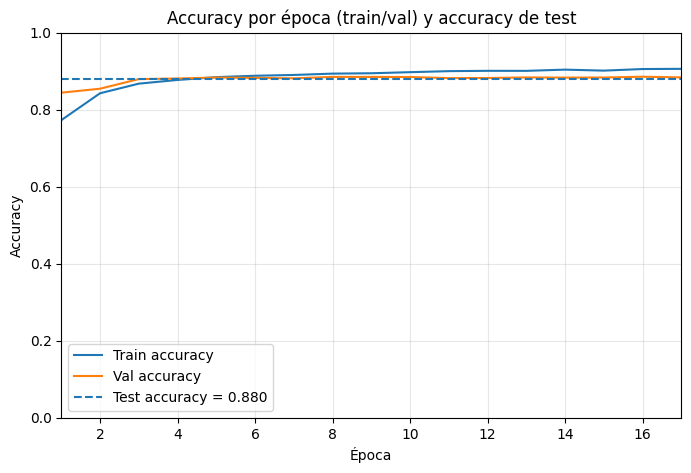

In [327]:
# Probabilidades (softmax) y P(A)
probs = model.predict(X_test_p, verbose=0)   # shape (n,2)
pA    = probs[:, 1]                          # P(A gana)

# Umbral fijo 0.5 como pediste
y_pred = (pA >= 0.5).astype(int)

print(classification_report(y_test, y_pred, digits=3))
print("ROC-AUC (A positiva):", roc_auc_score(y_test, pA))
print("LogLoss:", log_loss(y_test, probs))

# ---- Accuracy por época (train/val) + línea test ----
H = history.history
train_key = "accuracy" if "accuracy" in H else ("acc" if "acc" in H else None)
val_key   = "val_accuracy" if "val_accuracy" in H else ("val_acc" if "val_acc" in H else None)

import matplotlib.pyplot as plt
train_acc = np.array(H[train_key]); val_acc = np.array(H[val_key])
epochs = np.arange(1, len(train_acc)+1)
test_acc = accuracy_score(y_test, y_pred)

plt.figure(figsize=(8,5))
plt.plot(epochs, train_acc, label="Train accuracy")
plt.plot(epochs, val_acc,   label="Val accuracy")
plt.axhline(test_acc, linestyle="--", linewidth=1.5, label=f"Test accuracy = {test_acc:.3f}")
plt.title("Accuracy por época (train/val) y accuracy de test")
plt.xlabel("Época"); plt.ylabel("Accuracy"); plt.xlim(1, len(epochs)); plt.ylim(0,1)
plt.grid(True, alpha=0.3); plt.legend(); plt.show()

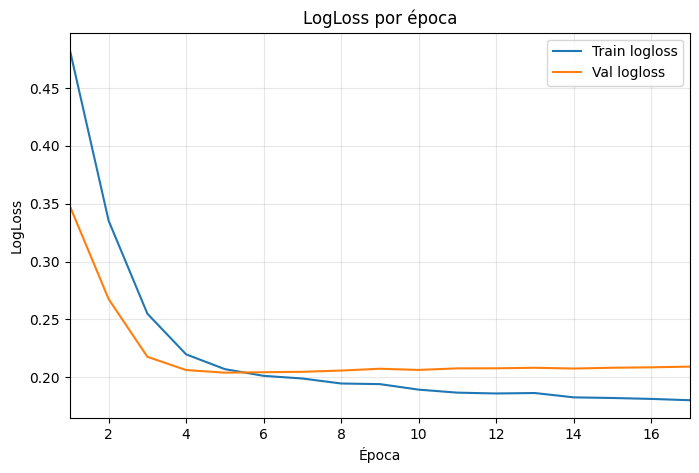

In [328]:
import numpy as np
import matplotlib.pyplot as plt

H = history.history  # devuelto por model.fit(...)
loss_tr = np.array(H["loss"])
loss_va = np.array(H["val_loss"])
epochs  = np.arange(1, len(loss_tr)+1)

plt.figure(figsize=(8,5))
plt.plot(epochs, loss_tr, label="Train logloss")
plt.plot(epochs, loss_va, label="Val logloss")
plt.title("LogLoss por época")
plt.xlabel("Época"); plt.ylabel("LogLoss")
plt.xlim(1, len(epochs))
plt.grid(True, alpha=0.3); plt.legend(); plt.show()

Mejoró un montón 